In [1]:
%cd ComputerVisionProject/

/home/group.kurse/cviwo012/ComputerVisionProject


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Clustering
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

from CellDataset import CellDataset
from MoCoResNetBackbone import MoCoResNetBackbone

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

In [3]:
def evaluate_unsupervised(X, labels_pred):
    if len(set(labels_pred)) > 1:
        sil = silhouette_score(X, labels_pred)
        db = davies_bouldin_score(X, labels_pred)
    else:
        sil, db = np.nan, np.nan
    return sil, db

def evaluate_supervised(y_true, y_pred):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    return ari, nmi

In [4]:
def plot_cluster_projections(reduced_results, cluster_labels, method_name="Unknown", save_dir=None):
    for reducer_name, X_2d in reduced_results.items():
        plt.figure(figsize=(7, 6))
        unique_labels = np.unique(cluster_labels)

        for label in unique_labels:
            mask = cluster_labels == label
            plt.scatter(
                X_2d[mask, 0], X_2d[mask, 1],
                s=5,
                alpha=0.3,
                label=f"{label}" if label != -1 else "Noise"
            )

        plt.legend(title="Cluster Label", loc="best", markerscale=3)
        # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='viridis', s=5, alpha=0.6)
        plt.title(f"{method_name} clustering shown via {reducer_name}")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.tight_layout()

        if save_dir:
            plt.savefig(Path(save_dir) / f"{method_name}_{reducer_name}_clusters.png", dpi=300)
            plt.close()
        else:
            plt.show()
            plt.close()

In [5]:
def extract_and_reduce_embeddings(checkpoint_path, val_list, device, label_mode='dead_alive', num_frames_labels=10, batch_size=64, reducers=None):
    # 1. Load model
    model = MoCoResNetBackbone()
    model.to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    # 2. Load dataset and DataLoader
    dataset = CellDataset(video_list=val_list, mode='inference', label_mode=label_mode, num_frames_labels=num_frames_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # 3. Extract embeddings and labels
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Extracting embeddings"):
            imgs = imgs.to(device, non_blocking=True)
            embeddings = model.encode_query(imgs).cpu().numpy()
            labels = labels.cpu().numpy()

            all_embeddings.append(embeddings)
            all_labels.append(labels)

    embeddings = np.concatenate(all_embeddings, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    # 4. Run dimensionality reduction
    reduced_results = {}
    if reducers is not None:
        for name, reducer in reducers.items():
            print(f"Running {name}...")
            reduced = reducer.fit_transform(embeddings)
            reduced_results[name] = reduced

    plot_cluster_projections(reduced_results=reduced_results, cluster_labels=labels, method_name='GT-Labels-dead-alive')#, save_dir='plots')

    return reduced_results, labels

In [6]:
def run_clustering_evaluation(label_mode, num_frames, cluster_configs, device, model_path, val_list, reduced_results=None, batch_size=64, pca_dimension=10):
    print(f"\n=== Running for label_mode='{label_mode}' | num_frames={num_frames} ===")

    # 1. Load model
    model = MoCoResNetBackbone()
    model.to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    # 2. Init dataset and labels
    dataset = CellDataset(video_list=val_list, mode='inference', label_mode=label_mode, num_frames_labels=num_frames)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # 3. Extract embeddings
    all_embeddings, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc=f"Extracting embeddings for '{label_mode}'"):
            imgs = imgs.to(device, non_blocking=True)
            embeddings = model.encode_query(imgs).cpu().numpy()
            labels = labels.cpu().numpy()
            all_embeddings.append(embeddings)
            all_labels.append(labels)

    embeddings = np.concatenate(all_embeddings, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    # 4. Apply PCA
    pca = PCA(n_components=pca_dimension)
    X_pca = pca.fit_transform(embeddings)

    # 5. Run clustering with different settings
    results = []
    for method_name, clusterer_factory in cluster_configs.items():
        print()
        model = clusterer_factory()
        labels_pred = model.fit_predict(X_pca)

        if reduced_results:
            method_name_pca = method_name+'_pca_'+str(pca_dimension)
            plot_cluster_projections(reduced_results, labels_pred, method_name=method_name_pca)#, save_dir="plots")

        sil, db = evaluate_unsupervised(X_pca, labels_pred)
        ari, nmi = evaluate_supervised(labels, labels_pred)
        n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)

        results.append({
            "LabelMode": label_mode,
            "Method": method_name,
            "#Clusters": n_clusters,
            "Silhouette": sil,
            "DBIndex": db,
            "ARI": ari,
            "NMI": nmi
        })

    return results

In [7]:
# ========== Configuration ==========
checkpoint_path = Path("/scratch/cv-course-group-5/models/training4/model_epoch50.pth")  # adjust if needed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

_json_path = Path('video_lists/train_test_split.json')

# Load the file
with open(_json_path, 'r') as f:
    _split_data = json.load(f)

# Access the train and test entries
train_list = _split_data.get("train", [])
test_list = _split_data.get("test", [])
val_list = _split_data.get("val", [])

In [ ]:
# Dimensionality reduction methods
reducers = {
    # === PCA (Linear Baseline) ===
    "PCA_2D": PCA(n_components=2),

    # === t-SNE with Cosine Distance ===
    "tSNE_perp10_cos": TSNE(n_components=2, perplexity=10, n_iter=1500,
                            learning_rate=300, init="pca", metric="cosine", random_state=42),
    "tSNE_perp30_cos": TSNE(n_components=2, perplexity=30, n_iter=1500,
                            learning_rate=300, init="pca", metric="cosine", random_state=42),
    "tSNE_perp50_cos": TSNE(n_components=2, perplexity=50, n_iter=1500,
                            learning_rate=300, init="pca", metric="cosine", random_state=42),

    # === Cosine Metric ===
    "UMAP_15_0.1_cos": umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.2, metric="cosine", random_state=42),
    "UMAP_30_0.0_cos": umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.2, metric="cosine", random_state=42),
    "UMAP_50_0.3_cos": umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.3, metric="cosine", random_state=42),
    "UMAP_100_0.5_cos": umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.8, metric="cosine", random_state=42),

    # === Correlation Metric ===
    "UMAP_30_0.1_corr": umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric="correlation", random_state=42),
    "UMAP_50_0.0_corr": umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.3, metric="correlation", random_state=42),
    "UMAP_100_0.3_corr": umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.7, metric="correlation", random_state=42),
}
# Define configs (you can expand this later)
cluster_2 = {
    "HDBSCAN": lambda: HDBSCAN(min_cluster_size=100, metric='cosine'),
    "GMM-2": lambda: GaussianMixture(n_components=2, covariance_type='full', random_state=42),
    "GMM-2_weights": lambda: GaussianMixture(n_components=2, covariance_type='full', random_state=42, weights_init=[0.96, 0.04]),
    "Agglomerative-2": lambda: AgglomerativeClustering(n_clusters=2, linkage='complete'),

    "Agglomerative-Ward-2": lambda: AgglomerativeClustering(n_clusters=2, linkage="ward"),
    "Agglomerative-Complete-2": lambda: AgglomerativeClustering(n_clusters=2, linkage="complete"),
    "Agglomerative-Average-2": lambda: AgglomerativeClustering(n_clusters=2, linkage="average"),
    "Agglomerative-Single-2": lambda: AgglomerativeClustering(n_clusters=2, linkage="single"),
}

cluster_3 = {
    "HDBSCAN": lambda: HDBSCAN(min_cluster_size=100),
    "GMM-3": lambda: GaussianMixture(n_components=3, covariance_type='full', random_state=42),
    "Agglomerative-3": lambda: AgglomerativeClustering(n_clusters=3, linkage='complete'),

    "Agglomerative-Ward-3": lambda: AgglomerativeClustering(n_clusters=3, linkage="ward"),
    "Agglomerative-Complete-3": lambda: AgglomerativeClustering(n_clusters=3, linkage="complete"),
    "Agglomerative-Average-3": lambda: AgglomerativeClustering(n_clusters=3, linkage="average"),
    "Agglomerative-Single-3": lambda: AgglomerativeClustering(n_clusters=3, linkage="single"),
}

In [14]:
np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])[:14]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

44140


Extracting embeddings: 100%|████████████████████████████████████████| 690/690 [00:30<00:00, 22.63it/s]
/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running tSNE_perp10_cos...


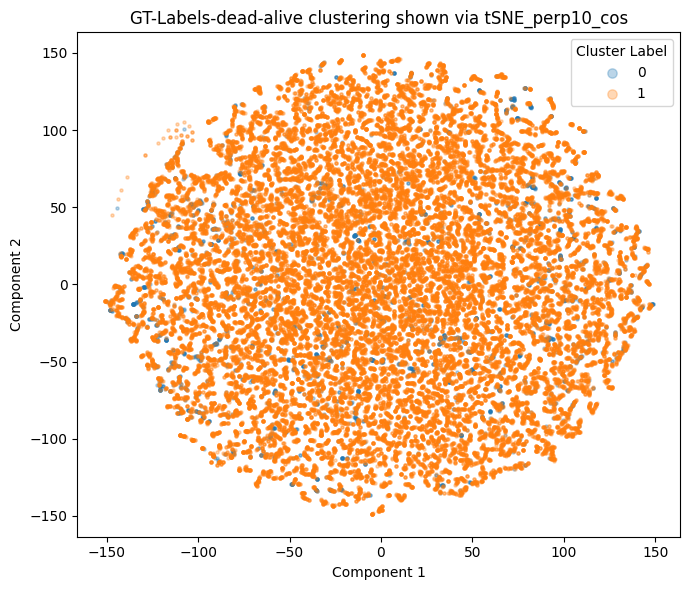


=== Running for label_mode='dead_alive' | num_frames=10 ===
44140


Extracting embeddings for 'dead_alive': 100%|███████████████████████| 690/690 [00:29<00:00, 23.08it/s]


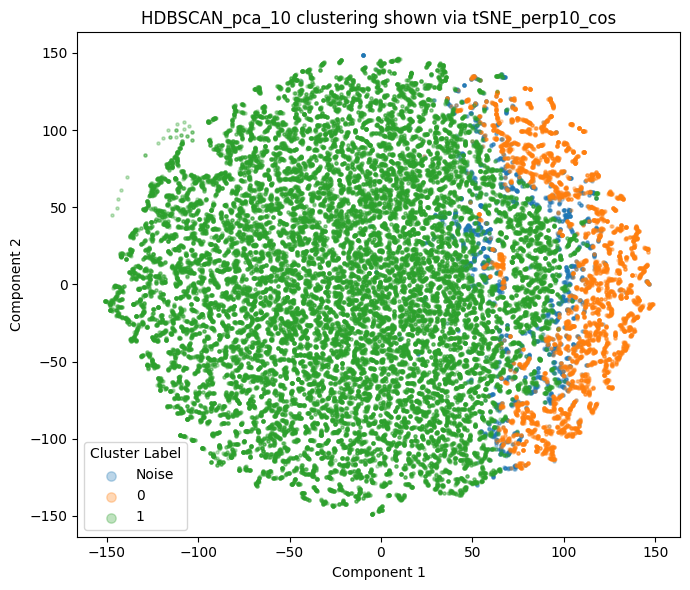

 LabelMode  Method  #Clusters  Silhouette  DBIndex     ARI      NMI
dead_alive HDBSCAN          2    0.659144 1.338762 0.01978 0.001077


In [ ]:
reduced_results, labels = extract_and_reduce_embeddings(
    checkpoint_path=checkpoint_path,
    val_list=val_list[:9],
    device=device,
    label_mode='dead_alive',
    num_frames_labels=10,
    batch_size=64,
    reducers=reducers
)
# Run for both label modes
results_all = []

r = run_clustering_evaluation(
    label_mode='dead_alive',
    num_frames=10,
    cluster_configs=cluster_2,
    device=device,
    model_path=checkpoint_path,
    val_list=val_list[:9],
    reduced_results=reduced_results,
    batch_size=batch_size
)
results_all.extend(r)

r = run_clustering_evaluation(
    label_mode='dead_alive_dividing',
    num_frames=10,
    cluster_configs=cluster_3,
    device=device,
    model_path=checkpoint_path,
    val_list=val_list[:16],
    reduced_results=reduced_results,
    batch_size=batch_size
)
results_all.extend(r)

# Convert to DataFrame and save
results_df = pd.DataFrame(results_all)
#results_df.to_csv("clustering_eval_results.csv", index=False)

print(results_df.to_string(index=False))